## Interfaz con Reinicio de Ventana

In [1]:
from tkinter import *
from tkinter import ttk
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg, NavigationToolbar2Tk
from tkcalendar import DateEntry
from datetime import datetime
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import mysql.connector
from sqlalchemy import create_engine
from matplotlib.figure import Figure
from tkinter import filedialog
import matplotlib.image as mpimg
from mysql.connector import Error
import numpy as np
import pandas as pd
import os

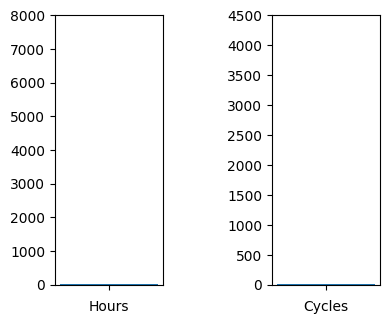

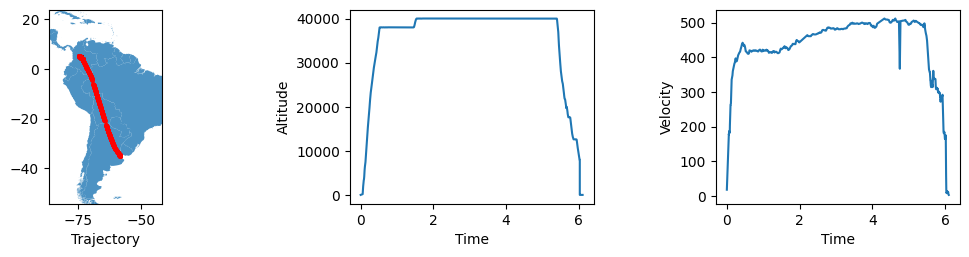

In [2]:
class InterfaceAV:
    def __init__(self):
        self.root = Tk()
        self.root.title('Flight and Maintenance Records Database')
        self.root.minsize(height=400, width=600)
        self.root.pack_propagate(False)
        self.frame1()

    def frame1(self):
        self.label1 = Label(self.root, text='Select a Model', font=('Roboto',20))
        self.label1.pack(pady=20)
        
        self.model_options = self.get_options('Model','modelos')
        self.model_var = StringVar()
        self.model_var.set("Model")
        self.model_menu = OptionMenu(self.root, self.model_var, *self.model_options)
        self.model_menu.pack(pady=20)
        
        self.button1 = Button(self.root, text='NEXT', font=('Roboto',13), command=self.frame2)
        self.button1.pack(side='bottom', pady=5)
        
    def frame2(self):
        self.label1.destroy()
        self.model_menu.destroy()
        self.button1.destroy()
        self.label2 = Label(self.root, text='Select an Aircraft', font=('Roboto',20))
        self.label2.pack(pady=20)
        
        self.id_options = self.update_id_options()
        self.id_var = StringVar()
        self.id_var.set("Aircraft ID")
        self.id_menu = OptionMenu(self.root, self.id_var, *self.id_options)
        self.id_menu.pack(pady=20)
        
        self.button2 = Button(self.root, text='NEXT', font=('Roboto',13), command=self.frame3)
        self.button2.pack(side='bottom', pady=5)
        self.button3 = Button(self.root, text='BACK', font=('Roboto',13), command=self.back_frame1)
        self.button3.pack(side='bottom', pady=5)
        
    def frame3(self):
        self.label2.destroy()
        self.id_menu.destroy()
        self.button2.destroy()
        self.button3.destroy()
        self.label3 = Label(self.root, text='Maintenance Data', font=('Roboto',20))
        self.label3.pack(pady=20)

        # Create a new frame to hold the procedure menu and check button
        self.procedure_frame = Frame(self.root)
        self.procedure_frame.pack(side=TOP, padx=5, pady=5)

        self.procedure_options = self.update_procedure_options()
        self.procedure_var = StringVar()
        self.procedure_var.set('Procedure')
        self.procedure_var.trace('w', self.on_option_select)
        self.procedure_menu = OptionMenu(self.procedure_frame, self.procedure_var, *self.procedure_options)
        self.procedure_menu.pack(side=LEFT)
        
        self.loadbutton = Button(self.root, text='Load Data', font=('Roboto',10), command=self.load_csv)
        self.loadbutton.pack(side=TOP, pady=5)

        self.button4 = Button(self.root, text='Flight Data', font=('Roboto',13), command=self.frame4)
        self.button4.pack(side='bottom', pady=5)        
        self.button5 = Button(self.root, text='BACK', font=('Roboto',13), command=self.back_frame2)
        self.button5.pack(side='bottom', pady=5)
    
    def on_option_select(self, *args):
        # Only plot the figure if a valid selection has been made
        if self.procedure_var.get() != 'Procedure':
            # Determine maintenance variables
            self.last_date = self.get_last_record()
            self.limits = self.get_limits()
            self.hours = self.get_hours()   
            self.total_hours = sum([float(x) for x in self.hours])
            self.total_cycles = float(self.get_cycles())        
            
            # To change last maintenance record
            self.date_label = Label(self.root, text=f'Last maintenance date\n {self.last_date}', font=('Roboto',13))
            self.date_label.place(relx=0.57, rely=0.3)
            self.date_label2 = Label(self.root, text='To update, select a date:', font=('Roboto',13))
            self.date_label2.place(relx=0.57, rely=0.4)
            self.date_var = StringVar()
            self.record_date_cal = DateEntry(self.root, width=12, background='lightgrey', foreground='white', borderwidth=2, textvariable=self.date_var)
            self.record_date_cal.place(relx=0.54, rely=0.47)
            self.savebutton = Button(self.root, text='Save Date', font=('Roboto',10), command=self.update_date)
            self.savebutton.place(relx=0.68, rely=0.8)
            
            # Add "Mileage" and "Cycles" bar plots to the "Maintenance"
            self.figure, self.ax = plt.subplots(1, 2)
            self.bar_plot = FigureCanvasTkAgg(self.figure, self.root)
            self.bar_plot.draw();
            #self.bar_plot.get_tk_widget().pack(fill=BOTH, expand=True, padx=10, pady=40)
            self.bar_plot.get_tk_widget().place(relx=0.19, rely=0.3, width=420, height=350)
            #self.bar_plot.get_tk_widget().place(relx=0.2, rely=0.3)

            self.ax[0].bar([''],[self.total_hours],width=1)
            self.ax[1].bar([''],[self.total_cycles],width=1)
            self.ax[0].set_ylim([0, float(self.limits[0][0])])
            self.ax[1].set_ylim([0, float(self.limits[0][1])])
            self.ax[0].set_xlabel('Hours')
            self.ax[1].set_xlabel('Cycles')
            self.figure.subplots_adjust(wspace=1)
    
    def frame4(self):
        self.root2 = Toplevel()
        self.root2.title('Flight and Maintenance Records Database')
        self.root2.minsize(height=600, width=800)
        self.label4 = Label(self.root2, text='Flight Data', font=('Roboto', 20))
        self.label4.pack(pady=10)
        
        self.flight_options = self.update_flight_options()
        self.flight_var = StringVar()
        self.flight_var.set("Flight")
        self.flight_var.trace('w', self.on_option_select2)
        self.flight_menu = OptionMenu(self.root2, self.flight_var, *self.flight_options)
        self.flight_menu.pack()

        self.root2.mainloop()
        
    def on_option_select2(self, *args):
        # Only plot the figure if a valid selection has been made
        if self.flight_var.get() != 'Flight':
            self.flight_vars = self.flight_var.get().split(' ')
            self.callsign = self.flight_vars[0]
            self.flight_date = self.flight_vars[1]
            
            # Add "Altitude", "Velocity" and "Trajectory" plots to the "Flight Data" LabelFrame
            vuelo = self.table2df(self.callsign, self.flight_date, self.id_var.get())
            
            time = vuelo['Time'].astype(float)
            altitude = vuelo['Altitude'].astype(float)
            velocity = vuelo['Speed'].astype(float)
            longitude = vuelo['Longitude'].astype(float)
            latitude = vuelo['Latitude'].astype(float)

            street_map = gpd.read_file('World_Countries_(Generalized)\World_Countries__Generalized_.shp')
            geometry = [Point(xy) for xy in zip(longitude, latitude)]
            gdf = GeoDataFrame(vuelo, geometry=geometry)

            self.figure2, self.ax2 = plt.subplots(1, 3, figsize=(1,1))
            self.flight_plot = FigureCanvasTkAgg(self.figure2, self.root2)
            self.flight_plot.draw();
            self.flight_plot.get_tk_widget().pack(fill=BOTH, expand=True, padx=10, pady=10)
            street_map.plot(ax=self.ax2[0], alpha=0.8)
            gdf.plot(ax=self.ax2[0], marker='o', color='red', markersize=5)
            self.ax2[1].plot(time,altitude)
            self.ax2[2].plot(time,velocity)

            self.ax2[0].set_xlabel('Trajectory')
            self.ax2[1].set_xlabel('Time')
            self.ax2[1].set_ylabel('Altitude')
            self.ax2[2].set_xlabel('Time')
            self.ax2[2].set_ylabel('Velocity')

            self.figure2.subplots_adjust(wspace=0.5, hspace=0.5)
            
            # Create the NavigationToolbar and add it to the first subplot
            self.toolbar = NavigationToolbar2Tk(self.flight_plot, self.root2)
            self.toolbar.update()
            self.toolbar.pack(side=TOP, fill=X)

            # Create scrollbar and treeview widgets
            scrollbar = ttk.Scrollbar(self.root2, orient="vertical")
            self.treeview = ttk.Treeview(self.root2, show="headings", yscrollcommand=scrollbar.set)

            scrollbar.pack(side="right", fill='y')
            scrollbar = ttk.Scrollbar(command=self.treeview.yview)

            # Add the columns to the treeview
            self.treeview['columns'] = list(vuelo.columns)

            # Set the column headings
            for column in self.treeview['columns']:
                self.treeview.heading(column, text=column)

            # Add the data rows to the treeview
            for index, row in vuelo.iterrows():
                self.treeview.insert('', END, values=list(row))

            # Pack the treeview into the root
            self.treeview.pack(fill="both", padx=10, pady=10)

    
    def table2df(self, callsign, date, ID):
        # Establish a connection to the database
        try:
            # Replace your_username, your_password, your_host, and your_database with your MySQL credentials
            engine = create_engine('mysql+mysqlconnector://root:@localhost/airlinedb')

            # Retrieve data from the database
            sql_query = f"SELECT * FROM vuelo WHERE matricula = '{ID}' AND callsign = '{callsign}' AND DATE(UTC) = '{date}';"

            # Read the query result into a pandas dataframe
            df = pd.read_sql(sql_query, engine)
            df = df.drop(['UTC', 'Callsign', 'Matricula', 'id_Vuelo'], axis=1)
            df = df.rename(columns={'Flight hours': 'Time'})
            
            return df

        except Exception as err:
            print(f"Error connecting to MySQL database: {err}")

        
    def connect(self, query, args=None, commit=False):
        # Connect to database
        try:
            self.connection = mysql.connector.connect(
                host='localhost',
                user='root',
                password='',
                database='airlinedb'
            )

            # Retrieve data from the database
            self.cursor = self.connection.cursor()

            # Execute the query using execute or executemany method
            if args is None:
                self.cursor.execute(query)
            else:
                self.cursor.executemany(query, args)

            # If commit is True, commit the changes to the database
            if commit:
                self.connection.commit()
                return None

            # Fetch the results of the query
            results = self.cursor.fetchall()

            return results

        except mysql.connector.Error as err:
            print(f"Error connecting to MySQL database: {err}")

    
    def get_options(self, column, table):
        # Retrieve data from the database
        items = self.connect(f'SELECT {column} FROM {table}')

        # Create a list of options from the database data
        self.options = [row[0] for row in items]

        return self.options
    
    def update_id_options(self):
        ref_model = self.model_var.get()
        # Retrieve data from the database depending on the selected model
        items = self.connect(f'SELECT aeronave.Matricula FROM aeronave JOIN modelos ON modelos.id_modelos = aeronave.modelo WHERE modelos.Model = "{ref_model}"')

        # Create a list of options from the database data
        self.options = [row[0] for row in items]

        return self.options
    
    def update_procedure_options(self):
        ref_model = self.model_var.get()
        # Retrieve data from the database depending on the selected model
        items = self.connect(f'SELECT tipo_de_mantenimiento.TipoDeMantenimiento FROM tipo_de_mantenimiento JOIN modelos ON modelos.id_modelos = tipo_de_mantenimiento.id_modelos WHERE modelos.Model = "{ref_model}"')

        # Create a list of options from the database data
        self.options = [row[0] for row in items]

        return self.options
    
    def update_flight_options(self):
        ref_ID = self.id_var.get()
        
        # Retrieve data from the database depending on the selected aircraft id
        query = f"""
        SELECT vuelo.Callsign, date(vuelo.UTC) as Date
        FROM vuelo
        INNER JOIN aeronave ON vuelo.Matricula = aeronave.Matricula
        WHERE aeronave.Matricula = '{ref_ID}'
        GROUP BY vuelo.Callsign, date(vuelo.UTC)
        ORDER BY date(vuelo.UTC) DESC;
        """

        items = self.connect(query)

        # Create a list of options from the database data
        self.options = [row[0] + ' ' + str(row[1]) for row in items]
        
        return self.options       
    
    def update_date(self):
        ref_ID = self.id_var.get()
        ref_tipo = self.procedure_var.get()
        
        if hasattr(self, "record_date_cal"):
            self.original_date = self.date_var.get()
            self.parsed_date = datetime.strptime(self.original_date, '%m/%d/%y')
            ref_date = self.parsed_date.strftime('%Y-%m-%d')
        
            if ref_tipo == 'Llantas':
                query = f"UPDATE aeronave SET mttoLlantas = '{ref_date}' WHERE Matricula = '{ref_ID}'"
            elif ref_tipo == 'Motor':
                query = f"UPDATE aeronave SET mttoMotores = '{ref_date}' WHERE Matricula = '{ref_ID}'"
            else:
                query = f"UPDATE aeronave SET mttoEstructura = '{ref_date}' WHERE Matricula = '{ref_ID}'"

            self.connect(query, commit=True)
    
    def get_last_record(self):
        ref_ID = self.id_var.get()
        ref_tipo = self.procedure_var.get()
        
        if ref_tipo == 'Llantas':
            query = f'SELECT mttoLlantas FROM aeronave WHERE Matricula = "{ref_ID}"'
        elif ref_tipo == 'Motor':
            query = f'SELECT mttoMotores FROM aeronave WHERE Matricula =  "{ref_ID}"'
        else:
            query = f'SELECT mttoEstructura FROM aeronave WHERE Matricula = "{ref_ID}"'
            
        items = self.connect(query)
        self.option = items[0][0]
        
        return self.option  
            
    
    def get_limits(self):
        ref_model = self.model_var.get()
        ref_tipo = self.procedure_var.get()
        
        query = f"""
        SELECT DISTINCT tipo_de_mantenimiento.HorasVuelo, tipo_de_mantenimiento.Ciclos FROM tipo_de_mantenimiento 
        JOIN modelos ON modelos.id_modelos = tipo_de_mantenimiento.id_modelos 
        WHERE modelos.Model = "{ref_model}" AND tipo_de_mantenimiento.TipoDeMantenimiento = "{ref_tipo}";
        """
        # Retrieve data from the database depending on the selected model
        items = self.connect(query)

        return items
    
    def get_hours(self):
        ref_ID = self.id_var.get()
        ref_last_date = self.last_date

        # Retrieve data from the database depending on the selected model

        query = f"""
        
        SELECT MAX(`Flight Hours`) AS MaxFlightHours
        FROM vuelo
        INNER JOIN aeronave ON vuelo.Matricula = aeronave.Matricula
        WHERE aeronave.Matricula = '{ref_ID}'
        AND DATE(vuelo.UTC) >= '{ref_last_date}'
        GROUP BY vuelo.Callsign, DATE(vuelo.UTC)
        ORDER BY DATE(vuelo.UTC) DESC;
        """

        #items = self.connect(f'SELECT Callsign, MAX(`Flight Hours`) AS MaxFlightHours FROM vuelo WHERE Matricula = "{ref_ID}" GROUP BY Callsign;')
        items = self.connect(query)

        # Create a list of options from the database data
        self.options = [row[0] for row in items]

        return self.options

    def get_cycles(self):
        ref_ID = self.id_var.get()
        ref_last_date = self.last_date
        
        query = f"""
        SELECT vuelo.Callsign, DATE(vuelo.UTC) AS Date
        FROM vuelo
        INNER JOIN aeronave ON vuelo.Matricula = aeronave.Matricula
        WHERE aeronave.Matricula = '{ref_ID}'
        AND DATE(vuelo.UTC) >= '{ref_last_date}'
        GROUP BY vuelo.Callsign, DATE(vuelo.UTC)
        ORDER BY DATE(vuelo.UTC) DESC;
        """
        # Retrieve data from the database depending on the selected model
        #items = self.connect(f'SELECT DISTINCT Callsign FROM vuelo WHERE Matricula="{ref_ID}"')
        items = self.connect(query)

        # Create a list of options from the database data
        self.options = [row[0] for row in items]

        return len(self.options)
        
    def load_csv(self):
        # Select and upload csv file
        file_path = filedialog.askopenfilename(filetypes=[("CSV Files", "*.csv")])
        vuelo = pd.read_csv(file_path)
    
        # Check if the user selected a file to classify it as used
        if file_path:
            dir_name = os.path.dirname(file_path)
            base_name = os.path.basename(file_path)

            # Create a new file name by adding "_new" to the base name
            new_name = os.path.join(dir_name, base_name.replace(".", "_used."))

            # Rename the file
            os.rename(file_path, new_name)
            
            # Treat flight data from csv file
            vuelo[['Latitude', 'Longitude']] = vuelo['Position'].str.split(',', expand=True)
            vuelo.drop('Position', axis=1, inplace=True)
            vuelo.drop('Direction', axis=1, inplace=True)
            vuelo["Timestamp"] = round((vuelo["Timestamp"] - vuelo["Timestamp"][0]) / 3600, 3)
            vuelo.rename(columns = {'Timestamp':'Flight hours'}, inplace = True)

            vuelo['Flight hours'] = vuelo['Flight hours'].astype(str)
            vuelo['Callsign'] = vuelo['Callsign'].astype(str)
            vuelo['Altitude'] = vuelo['Altitude'].astype(str)
            vuelo['Speed'] = vuelo['Speed'].astype(str)
            vuelo['Latitude'] = vuelo['Latitude'].astype(str)
            vuelo['Longitude'] = vuelo['Longitude'].astype(str)
            vuelo['Matricula'] = vuelo['Matricula'].astype(str)

            # Convert the dataframe to a list of tuples
            values = [tuple(x) for x in vuelo.to_records(index=False)]

            # Prepare the query for inserting data into the Flight table
            query = "INSERT INTO vuelo (`Flight hours`, UTC, Callsign, Altitude, Speed, Matricula, Latitude, Longitude) VALUES (%s, %s, %s, %s, %s, %s, %s, %s)"

            # Execute the query
            self.connect(query, args=values, commit=True);
            
        else:
            pass
    
    def back_frame1(self):
        self.label2.destroy()
        self.button2.destroy()
        self.button3.destroy()
        self.id_menu.destroy()
        self.frame1()
        
    def back_frame2(self):
        # destroy the bar plot canvas if it exists
        if hasattr(self, "bar_plot"):
            self.date_label.destroy()
            self.date_label2.destroy()
            self.bar_plot.get_tk_widget().pack_forget()
            self.bar_plot.get_tk_widget().destroy()
            self.savebutton.destroy()

        # Destroy the record date entry if it exists
        if hasattr(self, "record_date_cal"):
            self.record_date_cal.pack_forget()
            self.record_date_cal.destroy()

        # destroy all other widgets in frame3
        self.label3.destroy()
        self.procedure_menu.destroy()
        self.procedure_frame.destroy()
        self.loadbutton.destroy()
        self.button4.destroy()
        self.button5.destroy()
        self.frame2()

    def run(self):
        self.root.mainloop()
        self.cursor.close()
        self.connection.close()

my_interface = InterfaceAV()
my_interface.run()